In [ ]:
import sys
import os
sys.path.append(os.path.abspath('../lrp_chemprop/'))
from utils.glide_docking_monitor import glide_docking_monitor, visualize_glide_docking_monitor, glide_finished
from utils.glide_docking_processing import glide_result
from git import Repo
import time
import datetime
import numpy as np
import shutil

# **Glide docking monitor**

Note: When using this script, ensure your working directory is the folder containing glide-dock_SP_1, glide-dock_SP_2, etc. If it is not, please change your working directory to the parent folder of glide-dock_SP_* or specify the path for the job_name parameter.

In [ ]:
df = glide_docking_monitor(job_list = [1,2,3,4,5,6,7,8,9,10], job_name = 'glide-dock_SP')

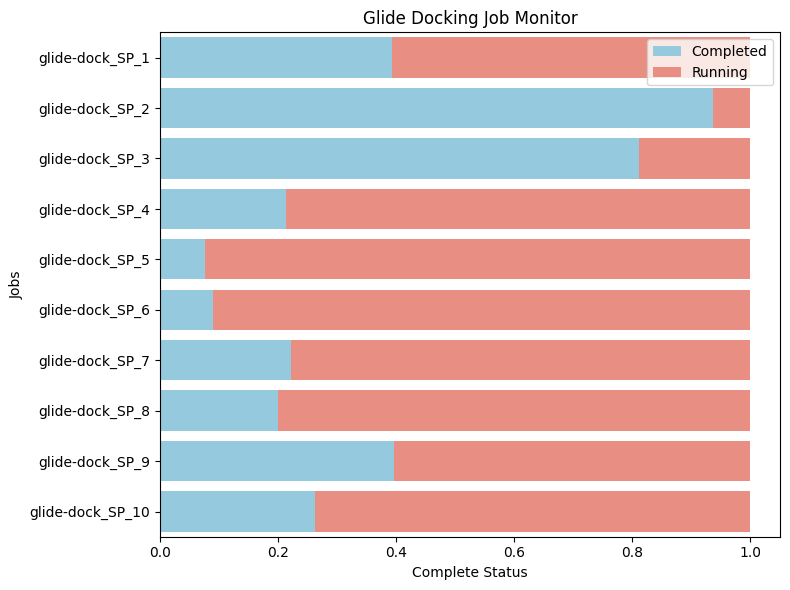

In [ ]:
visualize_glide_docking_monitor(df, xlabel = 'Complete Status', ylabel='Jobs', title='Docking Jobs Monitor', figsize=(10,8))

# **Handling glide results**

To select only lowest docking score among different poses of 1 molecule

In [ ]:
folder_name = 'glide-dock_SP_'
job_list = [2,3,4,9]

glide_result(folder_name,job_list)

# **Automatic Github Push**

When the docking rung for so long and you are not be able to use computer all the time, this scripts will help regconised finished jobs and upload processed file to github. Then, you just need to check it at home

In [ ]:
def git_push(repo_path, commit_message='new updates'):
    '''Push changes to GitHub repository'''
    repo = Repo(repo_path)
    repo.git.add(A=True)
    repo.index.commit(commit_message)
    origin = repo.remote(name='origin')
    origin.push()


def automatic_git_push(job_list, repo_path, sleep_time=3600, end_time=None):
    '''Automatically pushes to GitHub repository if jobs are completed, until the specified end time
    
    Parameters:
    ----------
    job_list (list): list of runing jobs.
    repo_path (path): path to your clone github repo.
    sleep_time (seconds): time waiting until the next update
    end_time (seconds): Ending time for the monitoring process'''

    # If no end_time is provided, set it to next Monday at midnight (during the weekend - our relax time)
    if end_time is None:
        today = datetime.datetime.now()
        days_until_next_monday = (7 - today.weekday()) % 7
        next_monday = today + datetime.timedelta(days=days_until_next_monday)
        end_time = datetime.datetime(next_monday.year, next_monday.month, next_monday.day, 0, 0)

    while datetime.datetime.now() < end_time:
        current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"\nRunning monitoring at {current_time}")

        try:
            finished_job = glide_finished(job_list, job_name='glide-dock_SP')
            if len(finished_job) == len(job_list):
                # Run glide results proccessing
                glide_result(folder_name='glide-dock_SP_',job_list=job_list)
                
                # Move file to clone repo
                for job in job_list:
                    shutil.move(folder_name+str(job)+'_processed.csv', repo_path+'/'+folder_name+str(job)+'_processed.csv')
                
                # push updates
                git_push(repo_path)
                print("Pushed changes to GitHub successfully")

        except Exception as e:
            print(f"Error during monitoring: {e}")

        print("Monitoring complete. Sleeping for 1 hour...\n")
        time.sleep(sleep_time)  # Sleep for 1 hour

In [ ]:
automatic_git_push(job_list=job_list, repo_path='docking_results', sleep_time=3600, end_time=None)